# Classificação de tópicos por embedding

Importe as bibliotecas necessárias

In [1]:
! pip install langdetect

     ---------------------------------------- 0.0/981.5 kB ? eta -:--:--
     ---------------------------------------- 10.2/981.5 kB ? eta -:--:--
     --- ----------------------------------- 81.9/981.5 kB 1.2 MB/s eta 0:00:01
     ------------------------ ------------- 634.9/981.5 kB 5.0 MB/s eta 0:00:01
     -------------------------------------- 981.5/981.5 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993255 sha256=22b4065152759f16974e3b4ccceb1e54df814934e6bc5ed9b77a751b6217443b
  Stored in direct

In [3]:
# Importing libraries
import regex as re
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from langdetect import detect
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import spacy
import nltk
nltk.download('punkt')
import pandas as pd
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Separação dos texto por frases

In [5]:

# Load the spacy model
nlp = spacy.load('en_core_web_sm')

# Load data
data = pd.read_csv('all_ECB_speeches.csv', sep='|')

# Function to detect language of a given text
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = "Unknown"
    return lang

# Apply the language detection function to each text in your DataFrame
data['language'] = data['contents'].apply(detect_language)

# Filter out the texts that are not in English
data = data[data['language'] == 'en']

# Drop null values
data = data.dropna(subset=['speakers', 'contents'])

# Reset index
data = data.reset_index(drop=True)

# Remove introduction
for row in range(data.shape[0]):
    try:
        speech = re.split(" \d+ (January|February|March|April|May|June|July|August|September|October|November|December) \d{4} ", data.loc[row, "contents"])
        data.loc[row, "contents"] = speech[-1]
    except:
        pass

# Split into sentences using spacy
def split_into_sentences(text):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    return sentences

sentences_list = []
for row in range(data.shape[0]):
    text = data.loc[row, "contents"]
    sentences = split_into_sentences(text)
    sentences_list.append(sentences)
data['sentences'] = sentences_list

# Explode the sentences column to have one sentence per row
sentences_df = data.explode('sentences').reset_index(drop=True)

sentences_df.to_csv('sentences_df.csv', index=False)


Lê o dataframe das sentenças e lê as predições feitas manualmente

In [36]:
sentences_df = pd.read_csv('sentences_df.csv')
my_predictions = pd.read_excel('my_predictions.xlsx')
predictions_adjusted = pd.read_csv('predictions_adjusted.csv')

In [37]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
predictions_adjusted = pd.read_csv('predictions_adjusted.csv')
predictions_adjusted = predictions_adjusted.loc[:, ~predictions_adjusted.columns.str.contains('^Unnamed')]
predictions_adjusted = predictions_adjusted.dropna(axis=1, how='all')
predictions_adjusted['Sentiment '].fillna('Unknown', inplace=True)
predictions_adjusted.head()

sid = SentimentIntensityAnalyzer()

def classify_sentiment(text):
    scores = sid.polarity_scores(text)
    compound_score = scores['compound']
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

predictions_adjusted['predicted_sentiment'] = predictions_adjusted['sentences'].apply(classify_sentiment)

from sklearn.metrics import classification_report

print(classification_report(predictions_adjusted['Sentiment '], predictions_adjusted['predicted_sentiment']))


              precision    recall  f1-score   support

    Negative       0.22      0.22      0.22        18
     Neutral       0.69      0.27      0.39        66
    Positive       0.20      0.79      0.32        14
     Unknown       0.00      0.00      0.00         1

    accuracy                           0.33        99
   macro avg       0.28      0.32      0.23        99
weighted avg       0.53      0.33      0.35        99



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
c:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWar

In [38]:
print(predictions_adjusted.head())

   RowNumber                Topic  \
0      10279  Atividade econômica   
1     205159  Atividade econômica   
2       3970               Nenhum   
3     115698               Nenhum   
4      55063  Atividade econômica   

                                           sentences Sentiment   \
0  Here in Estonia, wage growth is currently runn...   Negative   
1  The other half seems to be explained by a sign...   Negative   
2  Since our policies operate with lags, we canno...    Neutral   
3  The preparations are steered by a High-Level G...    Neutral   
4  First, the impact of reshoring and the automat...    Neutral   

  predicted_sentiment  
0            Positive  
1            Positive  
2            Positive  
3             Neutral  
4            Positive  


Coloque as frases classificadas no dataframe de sentenças

In [39]:
merged_df = sentences_df.merge(predictions_adjusted, on='sentences', how='left')
merged_df['Topic'].fillna('-', inplace=True)
merged_df['Sentiment '].fillna('-', inplace=True)

In [40]:
merged_df.columns

Index(['date', 'speakers', 'title', 'subtitle', 'contents', 'language',
       'sentences', 'RowNumber', 'Topic', 'Sentiment ', 'predicted_sentiment'],
      dtype='object')

### Treine o modelo

Crie um embedding para as sentenças classificadas

In [41]:
df_labeled = merged_df[merged_df['Topic'] != '-']

In [42]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch

# Carregar o tokenizer e o modelo
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

def embed_sentence(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Utilize a média dos embeddings da última camada
    embeddings = outputs.last_hidden_state.mean(dim=1)

    return embeddings.squeeze().numpy()

# Gerar embeddings para todas as sentenças
df_labeled['embeddings'] = df_labeled['sentences'].apply(embed_sentence)


C:\Users\georg\AppData\Local\Temp\ipykernel_21688\4279091857.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labeled['embeddings'] = df_labeled['sentences'].apply(embed_sentence)


Separe em treino e teste

In [43]:
from sklearn.model_selection import train_test_split

# Dividir os dados em conjuntos de treino e teste
X = list(df_labeled['embeddings'])
y = df_labeled['Topic']
# Separe 2 de 0.8 para treino e 0.2 para teste em cada tópico
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



Treine o classificador e avalie o conjunto de teste

Precision: A precisão é a proporção de identificações positivas que foram corretamente classificadas. É calculada como o número de verdadeiros positivos dividido pela soma de verdadeiros positivos e falsos positivos.

Sensibilidade ou taxa de verdadeiro positivo: O recall é a proporção de casos positivos reais que foram corretamente identificados pelo modelo.

F1-Score: É a média harmônica entre precisão e recall. É útil quando você deseja balancear precisão e recall. Um F1-Score perfeito é 1.00, o que indica precisão e recall perfeitos.

 Support: Refere-se ao número de ocorrências reais da classe no conjunto de dados especificado.

 Acurácia: É a proporção de previsões corretas, tanto verdadeiros positivos quanto verdadeiros negativos, em relação ao total de casos examinados.

 Macro Average: Calcula a média das métricas precisão, recall, F1-score para cada classe, sem levar em conta o suporte número de instâncias para cada classe.
 Weighted Average: Calcula a média das métricas considerando o suporte de cada classe. Isso significa que as classes com mais instâncias têm mais peso no cálculo da média.

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Treinar o classificador
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Avaliar o classificador
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))


                     precision    recall  f1-score   support

Atividade econômica       0.00      0.00      0.00         3
           Inflação       0.00      0.00      0.00         1
             Nenhum       0.81      1.00      0.89        25
 Política monetária       1.00      0.33      0.50         3

           accuracy                           0.81        32
          macro avg       0.45      0.33      0.35        32
       weighted avg       0.72      0.81      0.74        32



c:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [45]:
from sklearn.linear_model import LogisticRegression

# Treinar o classificador
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

# Avaliar o classificador
y_pred_log = log_reg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log))


Logistic Regression Classification Report:
                     precision    recall  f1-score   support

Atividade econômica       1.00      0.33      0.50         3
           Inflação       0.00      0.00      0.00         1
             Nenhum       0.83      1.00      0.91        25
 Política monetária       1.00      0.33      0.50         3

           accuracy                           0.84        32
          macro avg       0.71      0.42      0.48        32
       weighted avg       0.84      0.84      0.80        32



c:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [46]:
from sklearn.svm import SVC

# Treinar o classificador
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)

# Avaliar o classificador
y_pred_svm = svm_classifier.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))


SVM Classification Report:
                     precision    recall  f1-score   support

Atividade econômica       1.00      0.67      0.80         3
           Inflação       1.00      1.00      1.00         1
             Nenhum       0.93      1.00      0.96        25
 Política monetária       0.50      0.33      0.40         3

           accuracy                           0.91        32
          macro avg       0.86      0.75      0.79        32
       weighted avg       0.90      0.91      0.89        32



Classifique as sentenças não rotuladas

In [48]:
# Filtrar sentenças não rotuladas e gerar embeddings para um intervalo de sentenças na Christine Lagarde
mask = (merged_df['Topic'] == '-') & (merged_df['speakers'] == 'Christine Lagarde')
df_unlabeled = merged_df[mask]
# Gerar embeddings para sentenças não rotuladas
df_unlabeled['embeddings'] = df_unlabeled['sentences'].apply(embed_sentence)
print("Embeddings gerados para sentenças não rotuladas")
# Prever rótulos para sentenças não rotuladas
X_unlabeled = list(df_unlabeled['embeddings'])
y_unlabeled = classifier.predict(X_unlabeled)
df_unlabeled['Topic'] = y_unlabeled
print("Rótulos previstos para sentenças não rotuladas")
# Ver as predições
print(df_unlabeled[['sentences', 'Topic']])


Embeddings gerados para sentenças não rotuladas
Rótulos previstos para sentenças não rotuladas
                                               sentences   Topic
0      As we approach the end of this legislative ter...  Nenhum
1      Building on this collaborative spirit, today’s...  Nenhum
2      Let me start by outlining the current state of...  Nenhum
3      I will then focus on the need for a common Eur...  Nenhum
4      Bringing inflation back to target in a challen...  Nenhum
...                                                  ...     ...
36600  [2]According to the latest Eurobarometer surve...  Nenhum
36601      [3]Schäuble-Lamers Paper, 1 September 1994.    Nenhum
36602  [4]Interview with the Financial Times, 6 Octob...  Nenhum
36603  [5]Interview with the Financial Times, 22 Marc...  Nenhum
36604  [6]Interview with Bild am Sonntag, 3 October 2...  Nenhum

[8344 rows x 2 columns]


C:\Users\georg\AppData\Local\Temp\ipykernel_21688\3093847138.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unlabeled['embeddings'] = df_unlabeled['sentences'].apply(embed_sentence)
C:\Users\georg\AppData\Local\Temp\ipykernel_21688\3093847138.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unlabeled['Topic'] = y_unlabeled


Filtre os dados da Christine Lagarde  e classifique-os

In [49]:
filtered_df = df_unlabeled[df_unlabeled['Topic'] != 'Nenhum']

# Exibir o resultado
print(filtered_df[['sentences', 'Topic']])

                                               sentences                Topic
5      Having peaked at 10.6% in October 2022, inflat...  Atividade econômica
6      After expanding by 3.4% in 2022, euro area eco...  Atividade econômica
11     Unemployment stood at a historical low of 6.4%...  Atividade econômica
12      Inflation decreased slightly to 2.8% in January.  Atividade econômica
13     Energy prices declined by 6.1%, and food infla...  Atividade econômica
...                                                  ...                  ...
35638  One sign of this can be found by looking at th...  Atividade econômica
35639  It turns out that the group of surplus countri...   Política monetária
35666  The share of productive expenditure in total p...  Atividade econômica
35673  This is also reflected in differences in total...  Atividade econômica
35699  [3]Since the onset of the financial crisis, do...  Atividade econômica

[824 rows x 2 columns]


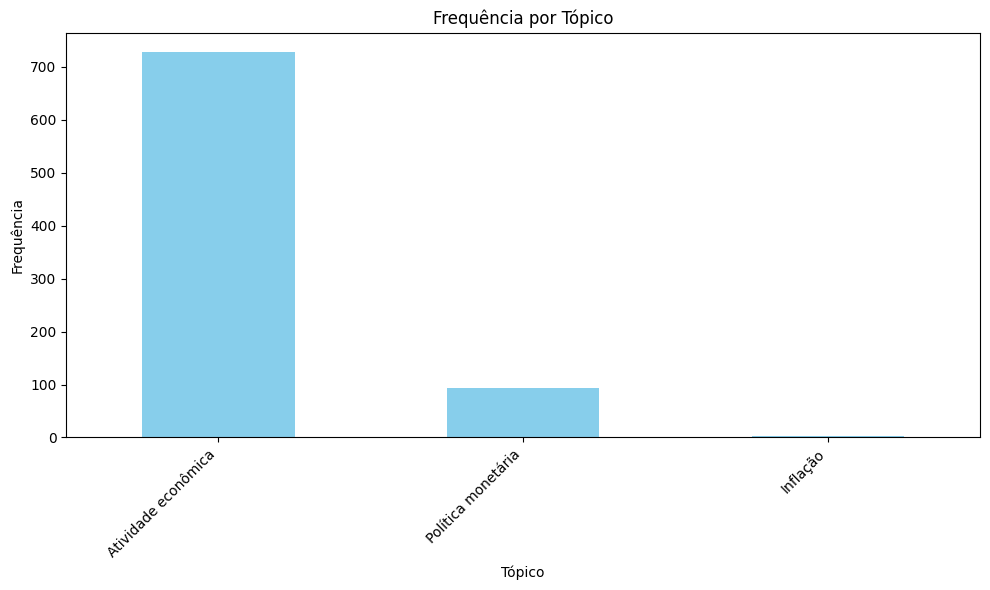

In [50]:
topic_counts = filtered_df['Topic'].value_counts()

# Criando o gráfico de barras
plt.figure(figsize=(10, 6))  # Ajusta o tamanho da figura
topic_counts.plot(kind='bar', color='skyblue')  # Gera um gráfico de barras
plt.title('Frequência por Tópico')  # Título do gráfico
plt.xlabel('Tópico')  # Rótulo do eixo X
plt.ylabel('Frequência')  # Rótulo do eixo Y
plt.xticks(rotation=45, ha='right')  # Rotação dos rótulos no eixo X para melhor visualização
plt.tight_layout()  # Ajusta automaticamente os subplots para dar espaço aos rótulos
plt.show()

In [51]:
# Junte os dados rotulados e não rotulados da Christine Lagarde
# Filtrar sentenças rotuladas da Christine Lagarde
mask = merged_df['speakers'] == 'Christine Lagarde'
df_lagarde = merged_df[mask]
# Juntar dados rotulados e não rotulados
df_lagarde = pd.concat([df_lagarde, df_unlabeled])

In [64]:
df_lagarde.loc[:, "Sentiment "] = df_lagarde.loc[:, "sentences"].apply(classify_sentiment)
df_lagarde["Sentiment "].value_counts()

Sentiment 
Neutral     10765
Positive     4077
Negative     1854
Name: count, dtype: int64

Sentiment            Negative  Neutral  Positive
Topic                                           
Atividade econômica       200      196       333
Inflação                    0        0         3
Nenhum                   1626    10560      3684
Política monetária         28        9        57


C:\Users\georg\AppData\Local\Temp\ipykernel_21688\4154966736.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.27434842249657065' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pivot_table.loc[index, col] = pivot_table.loc[index, col] / pivot_table.loc[index, :].sum()
C:\Users\georg\AppData\Local\Temp\ipykernel_21688\4154966736.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3703183435663913' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pivot_table.loc[index, col] = pivot_table.loc[index, col] / pivot_table.loc[index, :].sum()
C:\Users\georg\AppData\Local\Temp\ipykernel_21688\4154966736.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9980678043731027' has dtype incompati

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'Atividade econômica'),
  Text(0, 1.5, 'Inflação'),
  Text(0, 2.5, 'Nenhum'),
  Text(0, 3.5, 'Política monetária')])

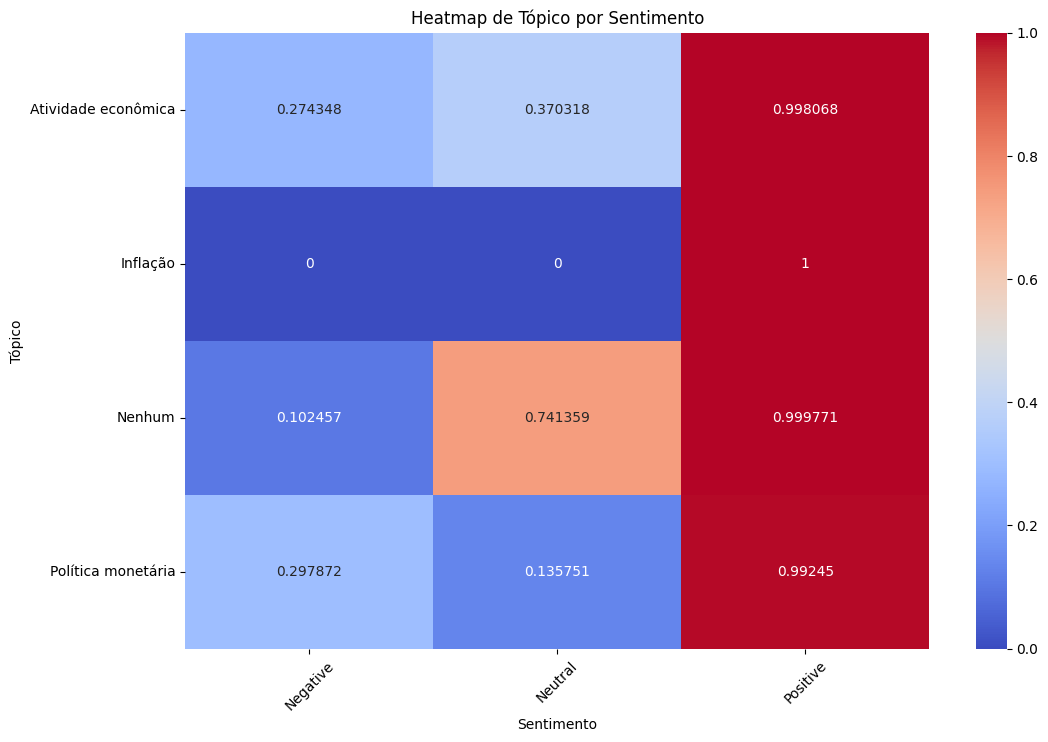

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Primeiro, calcular a matriz de contagem cruzada
df_lagarde.loc[df_lagarde['Topic'] == "-", "Topic"] = "Nenhum"
pivot_table = pd.crosstab(df_lagarde['Topic'], df_lagarde['Sentiment '])
second_table = pivot_table.copy()

for index in pivot_table.index:
    for col in pivot_table.columns:
        pivot_table.loc[index, col] = second_table.loc[index, col] / second_table.loc[index, :].sum()

# Agora, plotar o heatmap usando seaborn
plt.figure(figsize=(12, 8))  # Define o tamanho da figura
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt='g')  # Cria o heatmap
plt.title('Heatmap de Tópico por Sentimento')  # Título do gráfico
plt.xlabel('Sentimento')  # Rótulo do eixo X
plt.ylabel('Tópico')  # Rótulo do eixo Y
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo X para melhor visualização
plt.yticks(rotation=0)  # Mantém os rótulos do eixo Y na posição


In [ ]:

merged_df['Sentiment'] = merged_df.apply(lambda row: classify_sentiment(row['sentences']) if pd.isna(row['Sentiment ']) else row['Sentiment '], axis=1)